In [1]:
import torch
import time
import os
from PIL import Image
import torch
from torchvision.transforms import v2 as T
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, ConcatDataset
import cv2
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
import random

torch.cuda.is_available()

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

In [2]:

# Define paths to images and masks
IMAGE_PATH = "DataSet/Kvasir/images"
MASK_PATH = "DataSet/Kvasir/masks"
IMG_HEIGHT, IMG_WIDTH = 256, 256


# Custom Dataset Class
class PolypSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augment_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])
        self.transform = transform
        self.augment_transform = augment_transform

        # Ensure valid dataset
        if len(self.image_files) == 0 or len(self.mask_files) == 0:
            raise ValueError("No valid image or mask files found in the specified directories.")
        if len(self.image_files) != len(self.mask_files):
            raise ValueError("Mismatch in the number of images and masks.")

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel RGB
        mask = Image.open(mask_path).convert("L")   # Ensure 1-channel grayscale
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        if self.augment_transform:
            image, mask = self.augment_transform(image, mask)
            # mask = self.augment_transform(mask)
        # Binarize the mask to ensure values are 0 or 1
        mask = (mask > 0.5).float()

        return image, mask

# Transformations for images and masks
basic_transform = T.Compose([
    T.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize images and masks
    T.ToTensor()                        # Convert to tensors and normalize to [0, 1]
])

augmentation_transform = T.Compose([
    T.Resize((IMG_HEIGHT, IMG_WIDTH)),          # Resize images and masks
    T.RandomHorizontalFlip(p=0.9),             # Random horizontal flip
    T.RandomVerticalFlip(p=0.7),               # Random vertical flip
    T.RandomRotation(degrees=90, expand=False, fill=0),  # Random 90-degree rotation
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness/contrast adjustment
    T.ToTensor()                               # Convert to PyTorch tensors
])
# Create dataset for original data (basic transformation only)
original_dataset = PolypSegmentationDataset(
    IMAGE_PATH,
    MASK_PATH,
    transform=basic_transform,  # Only basic resizing and normalization
    augment_transform=None      # No augmentation here
)

# Create dataset for augmented data
augmented_dataset = PolypSegmentationDataset(
    IMAGE_PATH,
    MASK_PATH,
    transform=None,              # No basic transform; augmentations take care of resizing
    augment_transform=augmentation_transform  # Apply augmentations
)

# Combine original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split combined dataset into training and testing sets
train_size = int(0.8 * len(combined_dataset))  # 80% for training
test_size = len(combined_dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Confirm new dataset sizes
print(f"Original dataset size: {len(original_dataset)}")
print(f"Augmented dataset size: {len(augmented_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")


Original dataset size: 1000
Augmented dataset size: 1000
Combined dataset size: 2000
Training set size: 1600
Testing set size: 400


c:\Users\T2420380\.conda\envs\tf_cuda12_1\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [4]:
# Initialize the model
resunet_model = smp.ResUnet(
    encoder_name="resnet34",           # Choose encoder
    encoder_weights="imagenet",        # Use ImageNet pre-trained weights
    in_channels=3,                     # Model input channels (3 for RGB images)
    classes=1,                         # Output channels (1 for binary segmentation)
)

# Define the loss function (Binary Cross-Entropy for binary segmentation)
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(resunet_model.parameters(), lr=1e-4)


In [5]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resunet_model = resunet_model.to(device)

# Training loop
train_start_time = time.time()

num_epochs = 20
for epoch in range(num_epochs):
    resunet_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_mask = resunet_model(images)

        # Calculate loss
        loss = loss_fn(predicted_mask, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

train_end_time = time.time()
train_time = train_end_time - train_start_time

Epoch [1/20], Loss: 0.34161108449101446
Epoch [2/20], Loss: 0.14004910320043565
Epoch [3/20], Loss: 0.10501395888626576
Epoch [4/20], Loss: 0.08828191384673119
Epoch [5/20], Loss: 0.07751914341002702
Epoch [6/20], Loss: 0.0749342692270875
Epoch [7/20], Loss: 0.06772426892071963
Epoch [8/20], Loss: 0.06506807632744312
Epoch [9/20], Loss: 0.06056243062019348
Epoch [10/20], Loss: 0.0556754195317626
Epoch [11/20], Loss: 0.053406895194202664
Epoch [12/20], Loss: 0.048448139410465954
Epoch [13/20], Loss: 0.047710591331124305
Epoch [14/20], Loss: 0.05281832518056035
Epoch [15/20], Loss: 0.04711618999019265
Epoch [16/20], Loss: 0.04744042430073023
Epoch [17/20], Loss: 0.05338445022702217
Epoch [18/20], Loss: 0.045441755019128324
Epoch [19/20], Loss: 0.03934383066371083
Epoch [20/20], Loss: 0.041072555519640445


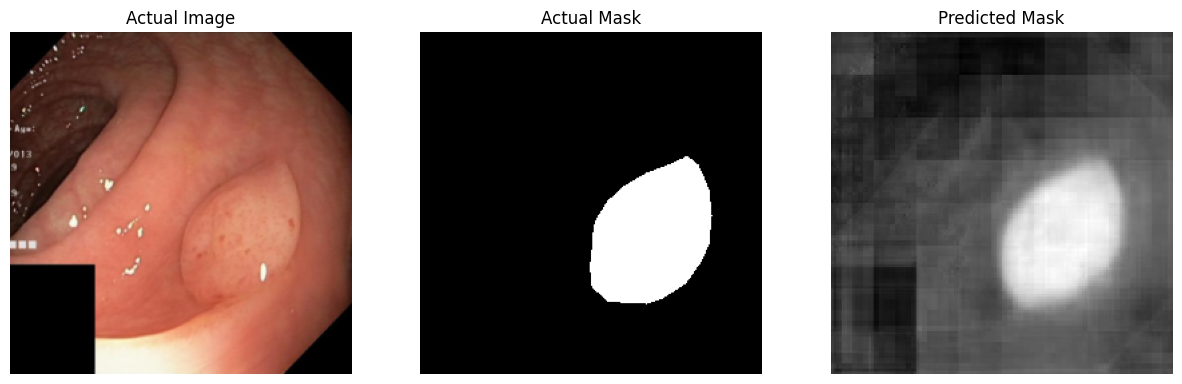

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a batch from the dataloader
images, masks = next(iter(test_loader))

# Pick the first image, mask, and predicted mask
image = images[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
mask = masks[0].cpu().numpy().squeeze()  # Remove channel dimension if mask is 1 channel
predicted_mask = resunet_model(images.to(device))[0].cpu().detach().numpy().squeeze()  # Get the predicted mask

# Plot the actual image, actual mask, and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display image
ax[0].imshow(image)
ax[0].set_title("Actual Image")
ax[0].axis('off')

# Display actual mask
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Actual Mask")
ax[1].axis('off')

# Display predicted mask
ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()


In [7]:

# Helper functions to calculate true positives, false positives, true negatives, and false negatives
def get_metrics(pred, target, threshold=0.5):
    # Convert to binary (0 or 1) predictions and targets
    pred = (pred > threshold).float()
    target = target.float()

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = (pred * target).sum()
    FP = ((1 - target) * pred).sum()
    TN = ((1 - pred) * (1 - target)).sum()
    FN = (target * (1 - pred)).sum()

    return TP, FP, TN, FN

# 1. Dice Similarity Coefficient (DSC)
def dice_coefficient(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return (2. * TP) / (2. * TP + FP + FN + 1e-6)

# 2. Intersection over Union (IoU)
def intersection_over_union(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FP + FN + 1e-6)

# 3. Accuracy
def accuracy(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return (TP + TN) / (TP + FP + TN + FN + 1e-6)

# 4. Sensitivity (Recall)
def sensitivity(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FN + 1e-6)

# 5. Specificity
def specificity(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TN / (TN + FP + 1e-6)

# 6. Precision
def precision(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FP + 1e-6)

# 7. F1-Score
def f1_score(pred, target, threshold=0.5):
    prec = precision(pred, target, threshold)
    rec = sensitivity(pred, target, threshold)
    return 2 * (prec * rec) / (prec + rec + 1e-6)

resunet_model.eval()  # Set the model to evaluation mode

# Initialize empty lists to store metrics
dice_scores = []
iou_scores = []
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
precision_scores = []
f1_scores = []


test_start_time = time.time()

# Iterate through the dataloader
for images, masks in test_loader:
    # Move tensors to GPU if necessary
    images = images.cuda()
    masks = masks.cuda()

    # Get the predicted mask from the model
    with torch.no_grad():
        predicted_mask = resunet_model(images)

    # Compute the performance metrics
    dice_scores.append(dice_coefficient(predicted_mask, masks).item())
    iou_scores.append(intersection_over_union(predicted_mask, masks).item())
    accuracy_scores.append(accuracy(predicted_mask, masks).item())
    sensitivity_scores.append(sensitivity(predicted_mask, masks).item())
    specificity_scores.append(specificity(predicted_mask, masks).item())
    precision_scores.append(precision(predicted_mask, masks).item())
    f1_scores.append(f1_score(predicted_mask, masks).item())

test_end_time = time.time()
test_time = test_end_time - test_start_time

# Calculate the average performance metrics across the dataset

print(f"Total training time: {train_time:.2f}s")
print(f"Total testing time: {test_time:.2f}s")
print(f"Average Dice Coefficient: {sum(dice_scores) / len(dice_scores):.4f}")
print(f"Average Intersection over Union (IoU): {sum(iou_scores) / len(iou_scores):.4f}")
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average Sensitivity (Recall): {sum(sensitivity_scores) / len(sensitivity_scores):.4f}")
print(f"Average Specificity: {sum(specificity_scores) / len(specificity_scores):.4f}")
print(f"Average Precision: {sum(precision_scores) / len(precision_scores):.4f}")
print(f"Average F1-Score: {sum(f1_scores) / len(f1_scores):.4f}")


Total training time: 426.85s
Total testing time: 4.37s
Average Dice Coefficient: 0.8979
Average Intersection over Union (IoU): 0.8167
Average Accuracy: 0.9716
Average Sensitivity (Recall): 0.8703
Average Specificity: 0.9898
Average Precision: 0.9330
Average F1-Score: 0.8979
